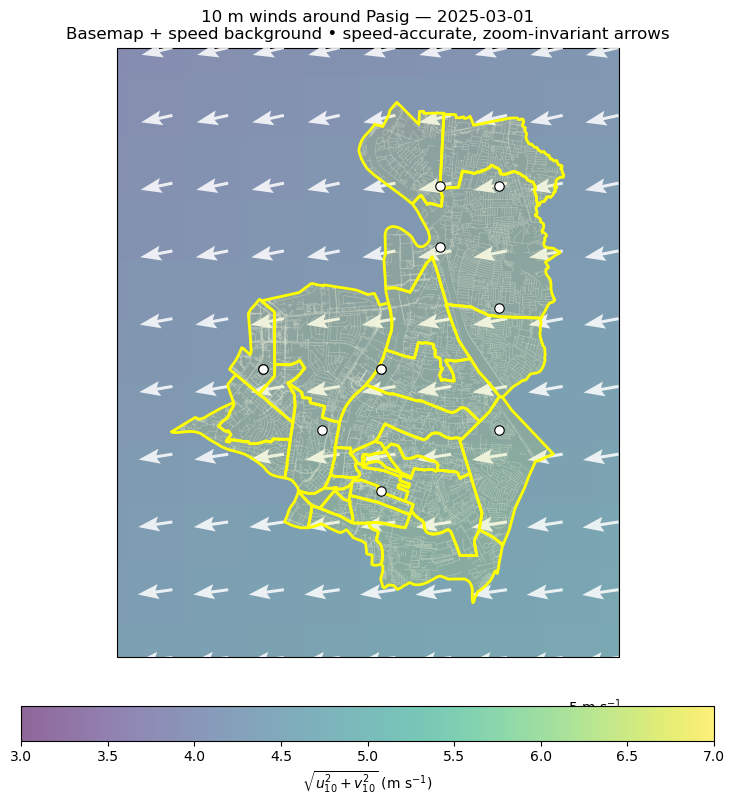

Saved: C:\Users\HP\Desktop\SpatialCARE\Outputs\figures\hotspots\pasig_speed_accurate_quiver_2025-03-01.png
Quiver scale used: 62.50 (so an arrow length fraction = speed / 62.50)


In [51]:
# ======================================================================
# Pasig wind map — speed-accurate, zoom-invariant quiver + safe basemap
# ======================================================================

import os, glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import fiona
from pathlib import Path

# Try online tiles if available (set True), else fallback automatically
USE_TILES = False
TILE_PROVIDER = "stamen-toner-lite"   # options: 'stamen-toner-lite', 'stamen-terrain'

# ---------------- PATHS ----------------
U_PATH       = r"C:\Users\HP\Desktop\SpatialCARE\Copernicus\10m_u_component_of_wind_stream-oper_daily-mean.nc"
V_PATH       = r"C:\Users\HP\Desktop\SpatialCARE\Copernicus\10m_v_component_of_wind_0_daily-mean.nc"
PASIG_SHP    = r"C:\Users\HP\Desktop\SpatialCARE\Pasig\Pasig.shp"
ROADS_SHP    = r"C:\Users\HP\Desktop\SpatialCARE\Pasig\PasigRN.shp"
DATA_DIR     = r"C:\Users\HP\Desktop\SpatialCARE\Daily\DailyGPKG"
OUT_F_DIR    = r"C:\Users\HP\Desktop\SpatialCARE\Outputs\figures\hotspots"
Path(OUT_F_DIR).mkdir(parents=True, exist_ok=True)

# ---------------- TOGGLES ----------------
TARGET_DATE       = "2025-03-01"
DISPLAY_BUFFER_KM = 1          # map view buffer around Pasig
SAMPLE_PAD_KM     = 80         # where winds are sampled from (wider = safer)
RES_BG_DEG        = 0.01       # background grid step (~1.1 km)

# Quiver density (how many arrows)
NQX, NQY          = 10, 10

# ---- SPEED-ACCURATE QUIVER SETTINGS (recommended) ----
# Choose visual length for a 5 m/s arrow as a fraction of axes width:
REF_SPEED_FOR_KEY = 5.0        # legend speed (m/s)
ARROW_FRACTION    = 0.08       # 5 m/s arrow spans 8% of axes width
# derived scale: arrow_length_fraction = speed / QUIVER_SCALE
QUIVER_SCALE      = REF_SPEED_FOR_KEY / ARROW_FRACTION  # e.g., 62.5 for 8%

# Arrow styling
QUIVER_WIDTH      = 0.006
HEAD_WIDTH, HEAD_LENGTH = 5, 7
ARROW_COLOR, ARROW_ALPHA = "white", 0.85

# (Keep these off for accuracy; we pass raw U,V)
NORMALIZE_ARROWS  = False       # must be False for true speed lengths
GAIN              = 1.0         # no amplification

# Layers / labels
ADD_ROADS         = True
LABEL_SENSORS     = True
SENSOR_NAME_COL   = "location_name"

# Background palette
CMAP_BG, ALPHA_BG = "viridis", 0.60
VMIN_VMAX         = (3, 7)      # fix scale for comparisons; set None to auto

# ======================================================================
def decode_valid_time(ds, time_var="valid_time"):
    vt = ds[time_var].values.astype("int64")
    base = np.datetime64("2025-02-01T00:00:00")
    shift = np.timedelta64(8, "h")
    return base + vt * np.timedelta64(1, "D") + shift

def km_to_deg(km, at_lat):
    dlat = km / 111.32
    dlon = km / (111.32 * np.cos(np.deg2rad(at_lat)))
    return dlon, dlat

def extent_from_pasig(gdf, pad_km):
    b = gdf.total_bounds
    mid_lat = (b[1] + b[3]) / 2
    dlon, dlat = km_to_deg(pad_km, mid_lat)
    return (b[0]-dlon, b[2]+dlon, b[1]-dlat, b[3]+dlat)

def pick_daily_gpkg(data_dir, date_str):
    cand = sorted(glob.glob(os.path.join(data_dir, f"*{date_str}*.gpkg")))
    if cand: return cand[0]
    all_gpkg = glob.glob(os.path.join(data_dir, "*.gpkg"))
    return max(all_gpkg, key=os.path.getmtime) if all_gpkg else None

def add_basemap(ax):
    """Try online tiles; if that fails (or disabled), add an offline basemap."""
    if USE_TILES:
        try:
            from cartopy.io.img_tiles import Stamen
            tiles = Stamen("toner-lite" if TILE_PROVIDER == "stamen-toner-lite" else "terrain-background")
            ax.add_image(tiles, 12)
            return
        except Exception as e:
            print("Basemap tiles unavailable; falling back to offline basemap:", e)
    # Offline fallback using Natural Earth features
    ax.add_feature(cfeature.LAND, facecolor="#f2efe9", zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor="#d6ecff", zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.6, zorder=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4, linestyle=":", zorder=1)
    ax.add_feature(cfeature.LAKES, facecolor="#d6ecff", edgecolor="none", alpha=0.6, zorder=0)
    ax.add_feature(cfeature.RIVERS, linewidth=0.3, alpha=0.4, zorder=0)

# ---- Load data ----
for p in (U_PATH, V_PATH, PASIG_SHP):
    if not os.path.exists(p): raise FileNotFoundError(p)

ds_u = xr.open_dataset(U_PATH, decode_times=False)
ds_v = xr.open_dataset(V_PATH, decode_times=False)
ds_u = ds_u.rename({"valid_time":"time"}).assign_coords(time=("time", decode_valid_time(ds_u)))
ds_v = ds_v.rename({"valid_time":"time"}).assign_coords(time=("time", decode_valid_time(ds_v)))

u10_full = ds_u["u10"].sel(time=np.datetime64(TARGET_DATE), method="nearest")
v10_full = ds_v["v10"].sel(time=np.datetime64(TARGET_DATE), method="nearest")
t_used = np.datetime_as_string(u10_full.time.values, unit="D")

pasig = gpd.read_file(PASIG_SHP).to_crs(4326)
lon_min_d, lon_max_d, lat_min_d, lat_max_d = extent_from_pasig(pasig, DISPLAY_BUFFER_KM)
lon_min_s, lon_max_s, lat_min_s, lat_max_s = extent_from_pasig(pasig, SAMPLE_PAD_KM)

# Subset to sampling extent
u10, v10 = u10_full, v10_full
if u10.latitude.values[0] > u10.latitude.values[-1]:
    u10 = u10.sel(latitude=slice(lat_max_s, lat_min_s), longitude=slice(lon_min_s, lon_max_s))
    v10 = v10.sel(latitude=slice(lat_max_s, lat_min_s), longitude=slice(lon_min_s, lon_max_s))
else:
    u10 = u10.sel(latitude=slice(lat_min_s, lat_max_s), longitude=slice(lon_min_s, lon_max_s))
    v10 = v10.sel(latitude=slice(lat_min_s, lat_max_s), longitude=slice(lon_min_s, lon_max_s))

# Interpolate background over sampling extent
lons_bg = np.arange(lon_min_s, lon_max_s + RES_BG_DEG/2, RES_BG_DEG)
lats_bg = np.arange(lat_min_s, lat_max_s + RES_BG_DEG/2, RES_BG_DEG)
grid_bg = {"longitude": xr.DataArray(lons_bg, dims="longitude"),
           "latitude":  xr.DataArray(lats_bg, dims="latitude")}
u_bg = u10.interp(grid_bg)
v_bg = v10.interp(grid_bg)
speed_bg = np.hypot(u_bg, v_bg)

# Fixed quiver grid over display extent
lons_q = np.linspace(lon_min_d, lon_max_d, NQX)
lats_q = np.linspace(lat_min_d, lat_max_d, NQY)
grid_q = {"longitude": xr.DataArray(lons_q, dims="longitude"),
          "latitude":  xr.DataArray(lats_q, dims="latitude")}
u_q_da = u_bg.interp(grid_q, kwargs={"fill_value":"extrapolate"})
v_q_da = v_bg.interp(grid_q, kwargs={"fill_value":"extrapolate"})
U, V = u_q_da.values, v_q_da.values  # <-- RAW m/s components (speed-accurate)
LON_Q, LAT_Q = np.meshgrid(lons_q, lats_q)

# ---- Plot ----
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(9.2, 9.0))
ax = plt.axes(projection=crs)
ax.set_extent([lon_min_d, lon_max_d, lat_min_d, lat_max_d], crs=crs)

add_basemap(ax)  # tiles if online; otherwise offline fallback

# Background speed (semi-transparent over basemap)
pc_kwargs = dict(cmap=CMAP_BG, shading="auto", alpha=ALPHA_BG, transform=crs, zorder=1)
if VMIN_VMAX is not None:
    pc_kwargs.update(dict(vmin=VMIN_VMAX[0], vmax=VMIN_VMAX[1]))
pc = ax.pcolormesh(u_bg.longitude, u_bg.latitude, speed_bg, **pc_kwargs)
cbar = plt.colorbar(pc, ax=ax, orientation="horizontal", fraction=0.05, pad=0.07)
cbar.set_label(r"$\sqrt{u_{10}^2 + v_{10}^2}$ (m s$^{-1}$)")

# Quiver (speed-accurate & zoom-invariant)
Q = ax.quiver(
    LON_Q, LAT_Q, U, V,                 # <-- raw m/s
    color=ARROW_COLOR, alpha=ARROW_ALPHA,
    angles="xy",
    units="width", scale_units="width", # stable across zoom, still proportional to speed
    scale=QUIVER_SCALE,                 # derived from REF_SPEED_FOR_KEY/ARROW_FRACTION
    width=QUIVER_WIDTH,
    headwidth=HEAD_WIDTH, headlength=HEAD_LENGTH, headaxislength=HEAD_LENGTH-1,
    transform=crs, zorder=3
)
ax.quiverkey(Q, X=0.88, Y=-0.08, U=REF_SPEED_FOR_KEY,
             label=f"{REF_SPEED_FOR_KEY:.0f} m s$^{{-1}}$", labelpos="E",
             coordinates="axes")

# Pasig highlight
pasig.plot(ax=ax, transform=crs, facecolor=(1,1,0,0.10), edgecolor="yellow", linewidth=2.0, zorder=5)

# Roads + sensors
roads, sensor_gdf = None, None
if ADD_ROADS and os.path.exists(ROADS_SHP):
    try: roads = gpd.read_file(ROADS_SHP).to_crs(4326)
    except Exception: pass
if roads is not None:
    roads.plot(ax=ax, transform=crs, color="white", linewidth=0.6, alpha=0.25, zorder=4)

gpkg_path = pick_daily_gpkg(DATA_DIR, t_used)
if gpkg_path:
    try:
        layers = fiona.listlayers(gpkg_path)
        for lyr in layers:
            gtmp = gpd.read_file(gpkg_path, layer=lyr)
            if not gtmp.empty and gtmp.geom_type.str.contains("Point", case=False).any():
                sensor_gdf = gtmp.to_crs(4326); break
    except Exception: pass

if sensor_gdf is not None and not sensor_gdf.empty:
    sensor_gdf.plot(ax=ax, transform=crs, color="white", edgecolor="black",
                    markersize=46, linewidth=0.8, zorder=6)
    if LABEL_SENSORS:
        name_col = SENSOR_NAME_COL if SENSOR_NAME_COL in sensor_gdf.columns else ("name" if "name" in sensor_gdf.columns else None)
        for _, r in sensor_gdf.iterrows():
            x, y = r.geometry.x, r.geometry.y
            label = str(r[name_col]) if name_col else ""
            ax.text(x+0.002, y+0.002, label, transform=crs, fontsize=8.5, color="white", zorder=7)

plt.title(f"10 m winds around Pasig — {t_used}\nBasemap + speed background • speed-accurate, zoom-invariant arrows", fontsize=12)
out_png = Path(OUT_F_DIR) / f"pasig_speed_accurate_quiver_{t_used}.png"
plt.savefig(out_png, dpi=240, bbox_inches="tight")
plt.show()
print("Saved:", out_png)
print(f"Quiver scale used: {QUIVER_SCALE:.2f} (so an arrow length fraction = speed / {QUIVER_SCALE:.2f})")

In [54]:
# ======================================================================
# Pasig wind map — render ALL timestamps (first to last) to PNG frames
# Speed-accurate, zoom-invariant quiver + safe basemap
# ======================================================================

import os, glob, re
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import fiona
from pathlib import Path

# ---------------- USER TOGGLES ----------------
USE_TILES          = False                 # True = try online tiles; False = offline Natural Earth fallback
TILE_PROVIDER      = "stamen-toner-lite"   # 'stamen-toner-lite' | 'stamen-terrain'

DISPLAY_BUFFER_KM  = 1                     # map view buffer around Pasig
SAMPLE_PAD_KM      = 80                    # where winds are sampled from (wider = safer)
RES_BG_DEG         = 0.01                  # background grid step (~1.1 km)
NQX, NQY           = 10, 10                # quiver density

# Quiver legend/scale (keep constant across all frames)
REF_SPEED_FOR_KEY  = 5.0                   # legend speed (m/s)
ARROW_FRACTION     = 0.08                  # 5 m/s arrow spans 8% of axes width
QUIVER_SCALE       = REF_SPEED_FOR_KEY / ARROW_FRACTION
QUIVER_WIDTH       = 0.006
HEAD_WIDTH, HEAD_LENGTH = 5, 7
ARROW_COLOR, ARROW_ALPHA = "white", 0.85
NORMALIZE_ARROWS   = False
GAIN               = 1.0

ADD_ROADS          = True
LABEL_SENSORS      = True
SENSOR_NAME_COL    = "location_name"

CMAP_BG, ALPHA_BG  = "viridis", 0.60
VMIN_VMAX          = (3, 7)                # fix scale across frames; set to None for per-frame autoscale

# Loop controls
START_AT_IDX       = 0                     # start at this time index (0-based)
END_AT_IDX         = None                  # end at this time index (inclusive). None = last
SKIP_EVERY         = 1                     # 1 = every frame; 2 = every 2nd; 3 = every 3rd, etc.

# ---------------- PATHS ----------------
U_PATH       = r"C:\Users\HP\Desktop\SpatialCARE\Copernicus\10m_u_component_of_wind_stream-oper_daily-mean.nc"
V_PATH       = r"C:\Users\HP\Desktop\SpatialCARE\Copernicus\10m_v_component_of_wind_0_daily-mean.nc"
PASIG_SHP    = r"C:\Users\HP\Desktop\SpatialCARE\Pasig\Pasig.shp"
ROADS_SHP    = r"C:\Users\HP\Desktop\SpatialCARE\Pasig\PasigRN.shp"
DATA_DIR     = r"C:\Users\HP\Desktop\SpatialCARE\Daily\DailyGPKG"
OUT_F_DIR    = r"C:\Users\HP\Desktop\SpatialCARE\Outputs\figures\wind_maps"  # change if you want a dedicated 'winds' folder
Path(OUT_F_DIR).mkdir(parents=True, exist_ok=True)

# ======================================================================
# Time handling
def decode_valid_time(ds, time_var="valid_time",
                      base_str="2025-02-01T00:00:00", unit="D", tz_shift_hours=8):
    """
    Your files appear to store integer 'valid_time' offsets in days from 2025-02-01 00:00,
    with a +8h shift to align to PHT. This reproduces your previous behavior.
    """
    if time_var not in ds:
        raise KeyError(f"'{time_var}' not found in dataset.")
    vt = ds[time_var].values.astype("int64")
    base = np.datetime64(base_str)
    shift = np.timedelta64(tz_shift_hours, "h")
    step = np.timedelta64(1, "D" if unit.upper().startswith("D") else "h")
    times = base + vt * step + shift
    return times

def ensure_time_coord(ds):
    """Return dataset with a proper datetime64 'time' coordinate."""
    if "time" in ds and np.issubdtype(ds["time"].dtype, np.datetime64):
        return ds
    elif "valid_time" in ds:
        times = decode_valid_time(ds, time_var="valid_time")
        return ds.rename({"valid_time": "time"}).assign_coords(time=("time", times))
    else:
        raise KeyError("No recognizable time coordinate ('time' or 'valid_time') found.")

# Geo helpers
def km_to_deg(km, at_lat):
    dlat = km / 111.32
    dlon = km / (111.32 * np.cos(np.deg2rad(at_lat)))
    return dlon, dlat

def extent_from_pasig(gdf, pad_km):
    b = gdf.total_bounds
    mid_lat = (b[1] + b[3]) / 2
    dlon, dlat = km_to_deg(pad_km, mid_lat)
    return (b[0]-dlon, b[2]+dlon, b[1]-dlat, b[3]+dlat)

def pick_daily_gpkg(data_dir, date_str):
    """Find a GPKG whose filename contains the ISO date (YYYY-MM-DD)."""
    cand = sorted(glob.glob(os.path.join(data_dir, f"*{date_str}*.gpkg")))
    if cand:
        return cand[0]
    # Fallback: nearest by YYYY-MM-DD in filename, if present
    all_gpkg = glob.glob(os.path.join(data_dir, "*.gpkg"))
    def extract_date(s):
        m = re.search(r"\d{4}[-_]\d{2}[-_]\d{2}", s)
        return m.group(0).replace("_","-") if m else None
    targets = [(p, extract_date(os.path.basename(p))) for p in all_gpkg]
    targets = [(p, np.datetime64(d)) for p,d in targets if d is not None]
    if not targets:
        return None
    want = np.datetime64(date_str)
    best = min(targets, key=lambda x: abs(x[1] - want))
    return best[0]

def add_basemap(ax):
    if USE_TILES:
        try:
            from cartopy.io.img_tiles import Stamen
            tiles = Stamen("toner-lite" if TILE_PROVIDER == "stamen-toner-lite" else "terrain-background")
            ax.add_image(tiles, 12)
            return
        except Exception as e:
            print("Basemap tiles unavailable; falling back to offline basemap:", e)
    ax.add_feature(cfeature.LAND, facecolor="#f2efe9", zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor="#d6ecff", zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.6, zorder=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4, linestyle=":", zorder=1)
    ax.add_feature(cfeature.LAKES, facecolor="#d6ecff", edgecolor="none", alpha=0.6, zorder=0)
    ax.add_feature(cfeature.RIVERS, linewidth=0.3, alpha=0.4, zorder=0)

def fmt_time_for_fname(t64):
    # YYYYMMDD or YYYYMMDD_HHMM if time has hours/minutes
    s_full = np.datetime_as_string(t64, unit="m")
    ymd = s_full[:10].replace("-", "")
    hm  = s_full[11:16].replace(":", "")
    return f"{ymd}_{hm}"

# ---- Load data (once) ----
for p in (U_PATH, V_PATH, PASIG_SHP):
    if not os.path.exists(p):
        raise FileNotFoundError(p)

ds_u = xr.open_dataset(U_PATH, decode_times=False)
ds_v = xr.open_dataset(V_PATH, decode_times=False)
ds_u = ensure_time_coord(ds_u)
ds_v = ensure_time_coord(ds_v)

# Intersect time coordinates present in BOTH U and V
times_u = ds_u["time"].values
times_v = ds_v["time"].values
times_all = np.array(sorted(np.intersect1d(times_u, times_v)))

if times_all.size == 0:
    raise RuntimeError("No overlapping timestamps between U and V datasets.")

# Optional slice/skip
start = max(0, START_AT_IDX)
end   = (len(times_all)-1) if END_AT_IDX is None else min(len(times_all)-1, END_AT_IDX)
times_to_plot = times_all[start:end+1][::max(1, int(SKIP_EVERY))]

print(f"Total timestamps (U∩V): {len(times_all)} | Rendering: {len(times_to_plot)}")
print(f"First: {times_to_plot[0]}  |  Last: {times_to_plot[-1]}")

# Static geodata & extents
pasig = gpd.read_file(PASIG_SHP).to_crs(4326)
lon_min_d, lon_max_d, lat_min_d, lat_max_d = extent_from_pasig(pasig, DISPLAY_BUFFER_KM)
lon_min_s, lon_max_s, lat_min_s, lat_max_s = extent_from_pasig(pasig, SAMPLE_PAD_KM)

roads = None
if ADD_ROADS and os.path.exists(ROADS_SHP):
    try:
        roads = gpd.read_file(ROADS_SHP).to_crs(4326)
    except Exception:
        roads = None

# Pre-build fixed quiver grid over display extent
lons_q = np.linspace(lon_min_d, lon_max_d, NQX)
lats_q = np.linspace(lat_min_d, lat_max_d, NQY)
grid_q = {"longitude": xr.DataArray(lons_q, dims="longitude"),
          "latitude":  xr.DataArray(lats_q, dims="latitude")}

# Loop over every timestamp
for i, t_cur in enumerate(times_to_plot, 1):
    # Select U,V at this time
    u10_full = ds_u["u10"].sel(time=t_cur)
    v10_full = ds_v["v10"].sel(time=t_cur)

    # Subset to sampling extent (handle latitude ordering)
    if u10_full.latitude.values[0] > u10_full.latitude.values[-1]:
        u10 = u10_full.sel(latitude=slice(lat_max_s, lat_min_s), longitude=slice(lon_min_s, lon_max_s))
        v10 = v10_full.sel(latitude=slice(lat_max_s, lat_min_s), longitude=slice(lon_min_s, lon_max_s))
    else:
        u10 = u10_full.sel(latitude=slice(lat_min_s, lat_max_s), longitude=slice(lon_min_s, lon_max_s))
        v10 = v10_full.sel(latitude=slice(lat_min_s, lat_max_s), longitude=slice(lon_min_s, lon_max_s))

    # Background grid (sampling extent)
    lons_bg = np.arange(lon_min_s, lon_max_s + RES_BG_DEG/2, RES_BG_DEG)
    lats_bg = np.arange(lat_min_s, lat_max_s + RES_BG_DEG/2, RES_BG_DEG)
    grid_bg = {"longitude": xr.DataArray(lons_bg, dims="longitude"),
               "latitude":  xr.DataArray(lats_bg, dims="latitude")}
    u_bg = u10.interp(grid_bg)
    v_bg = v10.interp(grid_bg)
    speed_bg = np.hypot(u_bg, v_bg)

    # Quiver vectors on fixed grid (display extent)
    u_q_da = u_bg.interp(grid_q, kwargs={"fill_value": "extrapolate"})
    v_q_da = v_bg.interp(grid_q, kwargs={"fill_value": "extrapolate"})
    U, V = u_q_da.values, v_q_da.values
    LON_Q, LAT_Q = np.meshgrid(lons_q, lats_q)

    # Optional sensor points for this day (match by YYYY-MM-DD)
    date_str = np.datetime_as_string(t_cur, unit="D")
    sensor_gdf = None
    gpkg_path = pick_daily_gpkg(DATA_DIR, date_str)
    if gpkg_path:
        try:
            layers = fiona.listlayers(gpkg_path)
            for lyr in layers:
                gtmp = gpd.read_file(gpkg_path, layer=lyr)
                if not gtmp.empty and gtmp.geom_type.str.contains("Point", case=False).any():
                    sensor_gdf = gtmp.to_crs(4326); break
        except Exception:
            sensor_gdf = None

    # ---- Plot
    crs = ccrs.PlateCarree()
    fig = plt.figure(figsize=(9.2, 9.0))
    ax = plt.axes(projection=crs)
    ax.set_extent([lon_min_d, lon_max_d, lat_min_d, lat_max_d], crs=crs)

    add_basemap(ax)

    pc_kwargs = dict(cmap=CMAP_BG, shading="auto", alpha=ALPHA_BG, transform=crs, zorder=1)
    if VMIN_VMAX is not None:
        pc_kwargs.update(dict(vmin=VMIN_VMAX[0], vmax=VMIN_VMAX[1]))
    pc = ax.pcolormesh(u_bg.longitude, u_bg.latitude, speed_bg, **pc_kwargs)
    cbar = plt.colorbar(pc, ax=ax, orientation="horizontal", fraction=0.05, pad=0.07)
    cbar.set_label(r"10-m wind speed (m s$^{-1}$)")

    Q = ax.quiver(
        LON_Q, LAT_Q, U, V,
        color=ARROW_COLOR, alpha=ARROW_ALPHA,
        angles="xy",
        units="width", scale_units="width",
        scale=QUIVER_SCALE,
        width=QUIVER_WIDTH,
        headwidth=HEAD_WIDTH, headlength=HEAD_LENGTH, headaxislength=HEAD_LENGTH-1,
        transform=crs, zorder=3
    )
    ax.quiverkey(Q, X=0.88, Y=-0.08, U=REF_SPEED_FOR_KEY,
                 label=f"{REF_SPEED_FOR_KEY:.0f} m s$^{{-1}}$", labelpos="E",
                 coordinates="axes")

    pasig.plot(ax=ax, transform=crs, facecolor=(1,1,0,0.10), edgecolor="yellow", linewidth=2.0, zorder=5)

    if roads is not None:
        roads.plot(ax=ax, transform=crs, color="white", linewidth=0.6, alpha=0.25, zorder=4)

    if sensor_gdf is not None and not sensor_gdf.empty:
        sensor_gdf.plot(ax=ax, transform=crs, color="white", edgecolor="black",
                        markersize=46, linewidth=0.8, zorder=6)
        if LABEL_SENSORS:
            name_col = SENSOR_NAME_COL if SENSOR_NAME_COL in sensor_gdf.columns else ("name" if "name" in sensor_gdf.columns else None)
            if name_col:
                for _, r in sensor_gdf.iterrows():
                    x, y = r.geometry.x, r.geometry.y
                    label = str(r[name_col])
                    ax.text(x+0.002, y+0.002, label, transform=crs, fontsize=8.5, color="white", zorder=7)

    t_label = np.datetime_as_string(t_cur, unit="D") if "T00:00" in np.datetime_as_string(t_cur) else np.datetime_as_string(t_cur, unit="m")
    plt.title(f"10 m winds around Pasig — {t_label}\nBasemap + speed background • speed-accurate, zoom-invariant arrows", fontsize=12)

    fname = f"pasig_speed_accurate_quiver_{fmt_time_for_fname(t_cur)}.png"
    out_png = Path(OUT_F_DIR) / fname
    plt.savefig(out_png, dpi=240, bbox_inches="tight")
    plt.close(fig)  # free memory between frames

    print(f"[{i:04d}/{len(times_to_plot):04d}] Saved: {out_png}")

print(f"Done. Frames written to: {OUT_F_DIR}")
print(f"Quiver scale used: {QUIVER_SCALE:.2f} (arrow length fraction = speed / {QUIVER_SCALE:.2f})")


Total timestamps (U∩V): 181 | Rendering: 181
First: 2025-02-01T08:00:00  |  Last: 2025-07-31T08:00:00
[0001/0181] Saved: C:\Users\HP\Desktop\SpatialCARE\Outputs\figures\wind_maps\pasig_speed_accurate_quiver_20250201_0800.png
[0002/0181] Saved: C:\Users\HP\Desktop\SpatialCARE\Outputs\figures\wind_maps\pasig_speed_accurate_quiver_20250202_0800.png
[0003/0181] Saved: C:\Users\HP\Desktop\SpatialCARE\Outputs\figures\wind_maps\pasig_speed_accurate_quiver_20250203_0800.png
[0004/0181] Saved: C:\Users\HP\Desktop\SpatialCARE\Outputs\figures\wind_maps\pasig_speed_accurate_quiver_20250204_0800.png
[0005/0181] Saved: C:\Users\HP\Desktop\SpatialCARE\Outputs\figures\wind_maps\pasig_speed_accurate_quiver_20250205_0800.png
[0006/0181] Saved: C:\Users\HP\Desktop\SpatialCARE\Outputs\figures\wind_maps\pasig_speed_accurate_quiver_20250206_0800.png
[0007/0181] Saved: C:\Users\HP\Desktop\SpatialCARE\Outputs\figures\wind_maps\pasig_speed_accurate_quiver_20250207_0800.png
[0008/0181] Saved: C:\Users\HP\Deskto

In [55]:
import os
import glob
from PIL import Image

# Folder where your PNG files are located
img_dir = r"C:\Users\HP\Desktop\SpatialCARE\Outputs\figures\wind_maps"

# Get all .png files sorted by filename (important for order)
png_files = sorted(glob.glob(os.path.join(img_dir, "*.png")))

# Load images
frames = [Image.open(f) for f in png_files]

# Output file
gif_path = os.path.join(img_dir, "Wind_Maps-10m.gif")

# Save as GIF
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=500,   # duration per frame in milliseconds (adjust speed here)
    loop=0          # 0 means infinite loop
)

print(f"GIF saved at: {gif_path}")


GIF saved at: C:\Users\HP\Desktop\SpatialCARE\Outputs\figures\wind_maps\Wind_Maps-10m.gif
